## Comparing all filtering methods

In [1]:
import Simulator
import Observation
import Statistics

import KalmanFilter
import ETKalmanFilter
import SLETKalmanFilter
import IEWParticleFilter

import Comparer

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [3]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


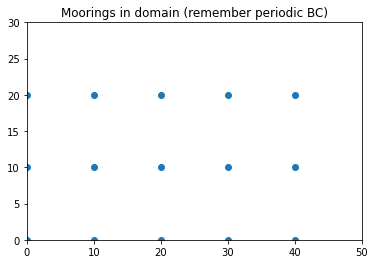

In [4]:
observation.plot_positions()

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [5]:
prior_args = Statistics.prior_args_from_file(timestamp)

## New truth if changes intended

In [6]:
new_truth = False

In [7]:
if new_truth:
    observation.clear_observations()
    observation.set_regular_positions(10)
    observation.plot_positions()
    print("N_y = ", len(observation.positions))


    # Temp changes only!
    simulator = Simulator.Simulator(grid, 
                                D=0.125, 
                                v=[1.5,0.5],
                                zeta=-0.0001,
                                dt=0.01,
                                noise_matern_phi=7.0,
                                noise_stddev=0.125)

    statistics_truth = Statistics.Statistics(simulator, 1)
    statistics_truth.set_prior(prior_args)

    for t in range(10):
        print(t)
        statistics_truth.propagate(25)
        #statistics_truth.plot()
        observation.observe(statistics_truth.mean)

In [8]:
stop_simulation_early = False

if stop_simulation_early:
    observation.N_obs = 1


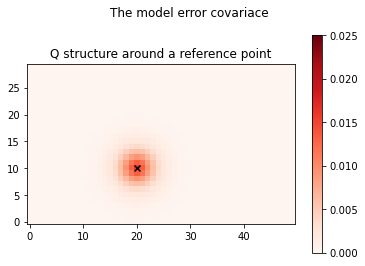

In [9]:
from matplotlib import pyplot as plt
import numpy as np
plt.suptitle("The model error covariace")
plt.title("Q structure around a reference point")
plt.imshow(np.reshape(simulator.cov_matrix()[520,:],(grid.ny,grid.nx)), origin="lower", vmin=0.0, vmax=0.025,cmap="Reds")
plt.colorbar()
plt.scatter(20,10, marker="x", c="black")

## Kalman filtering

Updating/conditioning the distributions at every observation time

Please remember to set priors!


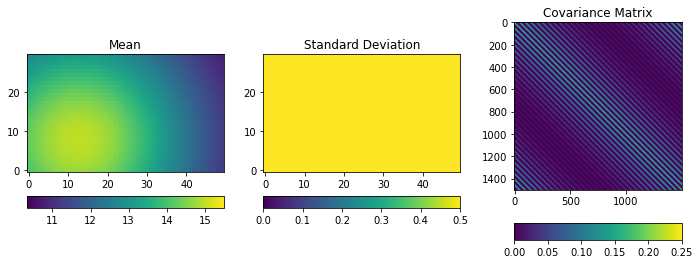

In [10]:
statistics_kf = Statistics.Statistics(simulator, safe_history=True)
statistics_kf.set_prior(prior_args)

statistics_kf.plot()

In [11]:
kalmanFilter = KalmanFilter.Kalman(statistics_kf, observation)

for t in range(observation.N_obs):
    print(t)
    statistics_kf.propagate(25)
    kalmanFilter.filter(statistics_kf.mean, statistics_kf.cov, observation.obses[t])
    #statistics_kf.plot()

0
1
2
3
4
5
6
7
8
9


# Ensemble-based filtering 

In [12]:
N_e = 250

## ETKF filtering

Updating/conditioning the distributions at every observation time

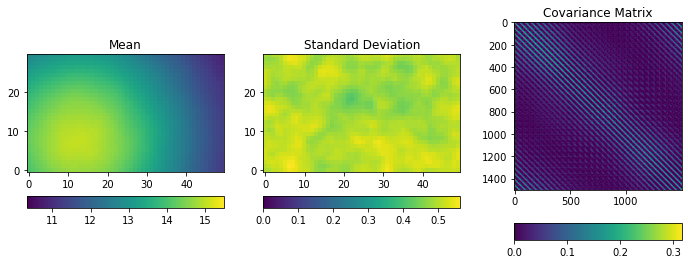

In [13]:
statistics_etkf = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_etkf.set_prior(prior_args)

statistics_etkf.plot()

In [14]:
etkFilter = ETKalmanFilter.ETKalman(statistics_etkf, observation)

for t in range(observation.N_obs):
    print(t)
    statistics_etkf.propagate(25)
    etkFilter.filter(statistics_etkf.ensemble.ensemble, observation.obses[t])
    #statistics_etkf.plot()

0
1
2
3
4
5
6
7
8
9


## LETKF filtering

Updating/conditioning the distributions at every observation time

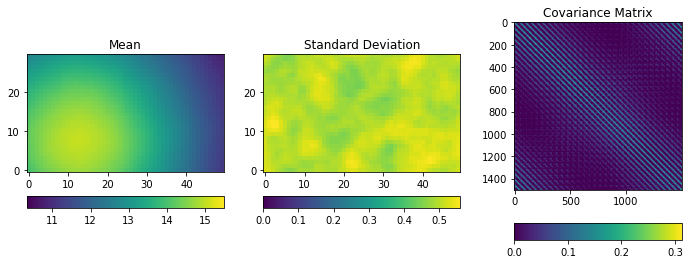

In [15]:
statistics_letkf = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_letkf.set_prior(prior_args)

statistics_letkf.plot()

In [16]:
from importlib import reload
reload(SLETKalmanFilter)

<module 'SLETKalmanFilter' from '/home/florianb/advectionDiffusion/SLETKalmanFilter.py'>

In [17]:
# We choose the scale_r as about 2/3 of the correlation length in grid cells 
scale_r = 5

In [18]:
sletkFilter = SLETKalmanFilter.SLETKalman(statistics_letkf, observation, scale_r)

In [19]:
sletkFilter.groups

[[0, 2], [1, 4], [11, 3], [6, 8], [5, 7], [9, 12], [14], [13, 10]]

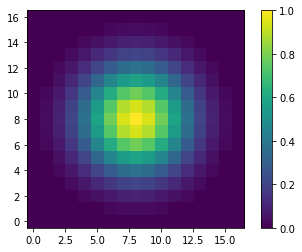

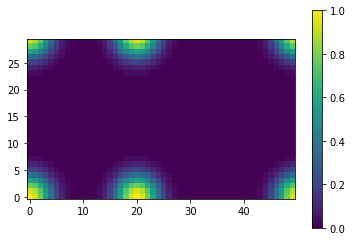

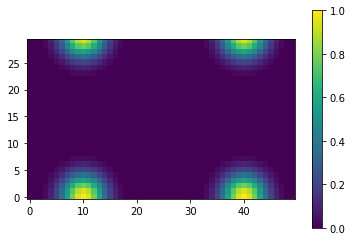

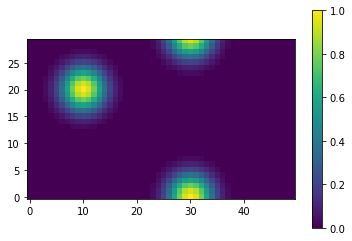

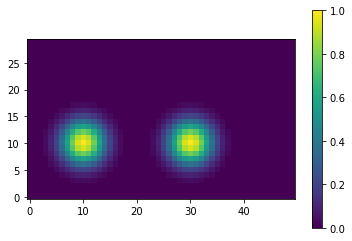

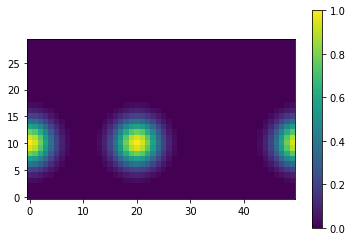

In [20]:
from matplotlib import pyplot as plt
plt.imshow(sletkFilter.W_loc, origin="lower", vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()
for g in range(min(5,len(sletkFilter.groups))):
    plt.imshow(sletkFilter.W_analyses[g], origin="lower", vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.show()

In [21]:
for t in range(observation.N_obs):
    print(t)
    statistics_letkf.propagate(25)
    sletkFilter.filter(statistics_letkf.ensemble.ensemble, observation.obses[t])
    #statistics_letkf.plot()

0
1
2
3
4
5
6
7
8
9


## IEWPF filtering

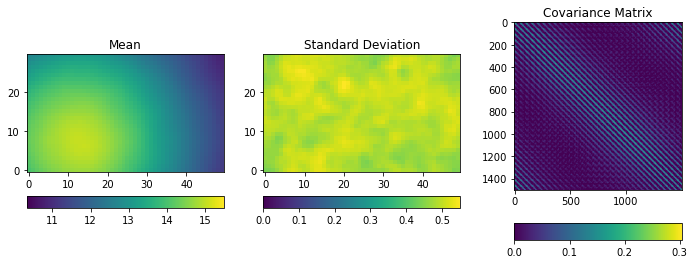

In [22]:
statistics_iewpf = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_iewpf.set_prior(prior_args)

statistics_iewpf.plot()

In [23]:
from importlib import reload
reload(IEWParticleFilter)

<module 'IEWParticleFilter' from '/home/florianb/advectionDiffusion/IEWParticleFilter.py'>

In [24]:
iewpFilter = IEWParticleFilter.IEWParticle(statistics_iewpf, observation, 0.55)

for t in range(observation.N_obs):
    print(t)
    statistics_iewpf.propagate(25, model_error=False)
    iewpFilter.filter(statistics_iewpf.ensemble.ensemble, observation.obses[t])
    #statistics_iewpf.plot()

0
Model error in historical forecast added
1
Model error in historical forecast added
2
Model error in historical forecast added
3
Model error in historical forecast added
4
Model error in historical forecast added
5
Model error in historical forecast added
6
Model error in historical forecast added
7
Model error in historical forecast added
8
Model error in historical forecast added
9
Model error in historical forecast added


## Monte Carlo Experiment

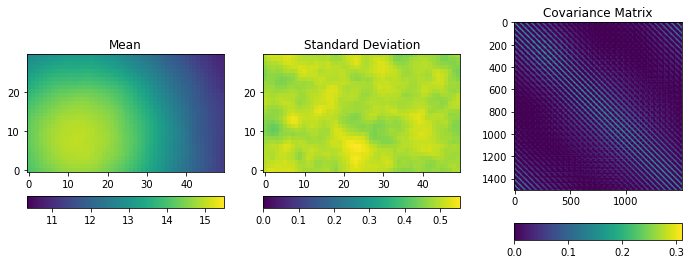

In [25]:
statistics_mc = Statistics.Statistics(simulator, N_e, safe_history=True)
statistics_mc.set_prior(prior_args)

statistics_mc.plot()

In [26]:
for t in range(observation.N_obs):
    print(t)
    statistics_mc.propagate(25, model_error=False)
    #statistics_mc.plot()

0
Model error in historical forecast added
1
Model error in historical forecast added
2
Model error in historical forecast added
3
Model error in historical forecast added
4
Model error in historical forecast added
5
Model error in historical forecast added
6
Model error in historical forecast added
7
Model error in historical forecast added
8
Model error in historical forecast added
9
Model error in historical forecast added


## Comparison

In [27]:
result_timestamp = None

In [28]:
from importlib import reload  
reload(Comparer)

<module 'Comparer' from '/home/florianb/advectionDiffusion/Comparer.py'>

In [29]:
comparer = Comparer.Comparer(statistics_kf, statistics_etkf, statistics_letkf, statistics_iewpf)

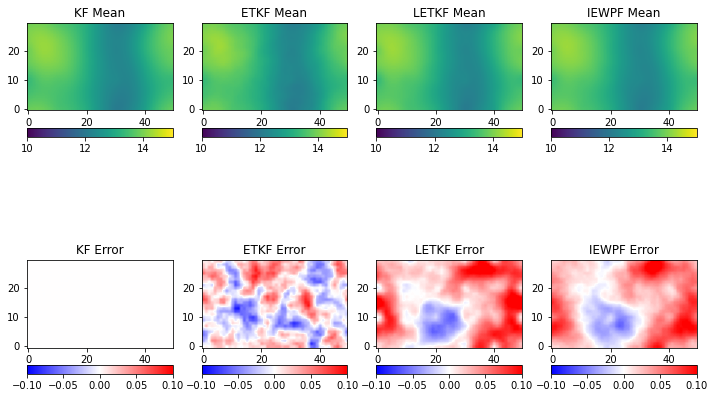

In [30]:
mean_err_etkf, mean_err_letkf, mean_err_iewpf = comparer.mean_plots()

In [31]:
save_rmse = False

In [32]:
if save_rmse: 
    import numpy as np
    import datetime 
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    result_timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    filepath = "experiment_files/experiment_" + timestamp + "/"
    
    xgrid = np.arange(grid.nx)*grid.dx
    ygrid = np.arange(grid.ny)*grid.dy
    xgrids, ygrids = np.meshgrid(xgrid,ygrid)

    fig1, ax1 = plt.subplots(figsize=(6,4))
    im1 = ax1.imshow(mean_err_etkf, origin = "lower", vmin=-0.175, vmax=0.175, cmap="bwr")
    plt.tight_layout()
    plt.savefig(filepath + "rmse_etkf_" + result_timestamp + ".png")
    plt.show()

    table_mean_err_etkf = np.column_stack((xgrids.flatten(), ygrids.flatten(), mean_err_etkf.flatten()))
    np.savetxt(filepath + "rmse_etkf.csv", table_mean_err_etkf, header='x, y, err', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')

    fig2, ax2 = plt.subplots(figsize=(6,4))
    im2 = ax2.imshow(mean_err_letkf, origin = "lower", vmin=-0.175, vmax=0.175, cmap="bwr")
    ax_divider = make_axes_locatable(ax2)
    ax_cb = ax_divider.append_axes("right", size="3%", pad="5%")
    cbar = plt.colorbar(im2, cax=ax_cb)
    cbar.ax.tick_params(labelsize=14) 
    plt.tight_layout()
    plt.savefig(filepath + "rmse_letkf_" + result_timestamp + ".png")
    plt.show()

    table_mean_err_letkf = np.column_stack((xgrids.flatten(), ygrids.flatten(), mean_err_letkf.flatten()))
    np.savetxt(filepath + "rmse_letkf.csv", table_mean_err_letkf, header='x, y, err', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')


    fig3, ax3 = plt.subplots(figsize=(6,4))
    im3 = ax3.imshow(mean_err_iewpf, origin = "lower", vmin=-0.175, vmax=0.175, cmap="bwr")
    plt.tight_layout()
    plt.savefig(filepath + "rmse_iewpf_" + result_timestamp + ".png")
    plt.show()

    table_mean_err_iewpf = np.column_stack((xgrids.flatten(), ygrids.flatten(), mean_err_iewpf.flatten()))
    np.savetxt(filepath + "rmse_iewpf.csv", table_mean_err_iewpf, header='x, y, err', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')


In [33]:
mean_rmse_kf, mean_rmse_etkf, mean_rmse_letkf, mean_rmse_iewpf = comparer.mean_rmse()

print("RMSE of KF = ", mean_rmse_kf)
print("RMSE of ETKF = ", mean_rmse_etkf)
print("RMSE of LETKF = ", mean_rmse_letkf)
print("RMSE of IEWPF = ", mean_rmse_iewpf)

RMSE of KF =  0.0
RMSE of ETKF =  1.2225474826420266
RMSE of LETKF =  1.9377299820077907
RMSE of IEWPF =  1.746633378204592


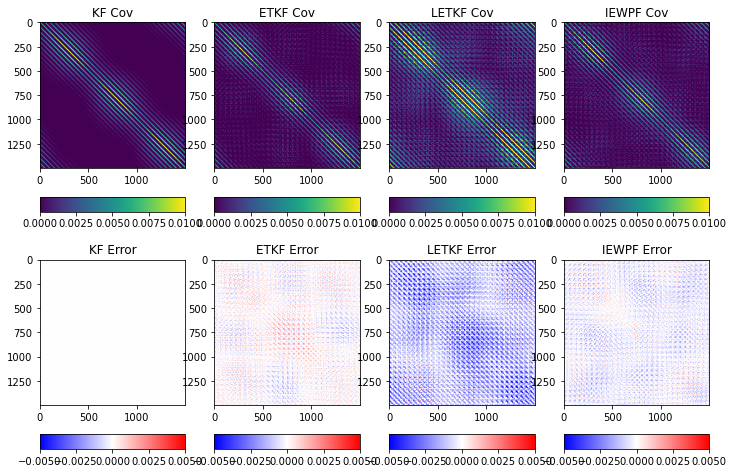

In [34]:
comparer.cov_plots()

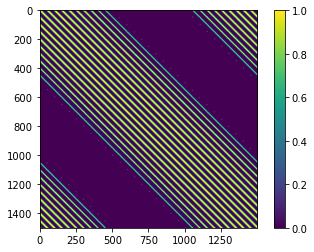

Meaning  0.20333333333333334 % of the domain is considered as close


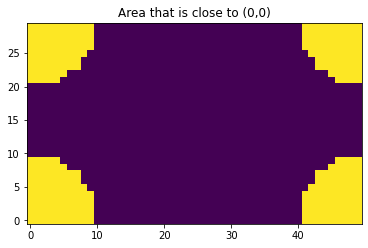

In [35]:
plt.imshow(grid.dist_mat<1)
plt.colorbar()
plt.show()

print("Meaning ", np.sum(grid.dist_mat[0]<1)/(grid.dist_mat.shape[0]), "% of the domain is considered as close")

plt.imshow(np.reshape(grid.dist_mat[0]<1,(grid.ny, grid.nx)), origin="lower")
plt.title("Area that is close to (0,0)")
plt.show()

In [36]:
cov_frob_kf, cov_frob_etkf, cov_frob_letkf, cov_frob_iewpf = comparer.cov_frobenius_dist()

print("Frobenius error in Cov matrix (KF) = ", cov_frob_kf)
print("Frobenius error in Cov matrix (ETKF) = ", cov_frob_etkf)
print("Frobenius error in Cov matrix (LETKF) = ", cov_frob_letkf)
print("Frobenius error in Cov matrix (IEWPF) = ", cov_frob_iewpf)

Frobenius error in Cov matrix (KF) =  0.0
Frobenius error in Cov matrix (ETKF) =  1.592581408361892
Frobenius error in Cov matrix (LETKF) =  2.961620602253586
Frobenius error in Cov matrix (IEWPF) =  1.6361987835977845


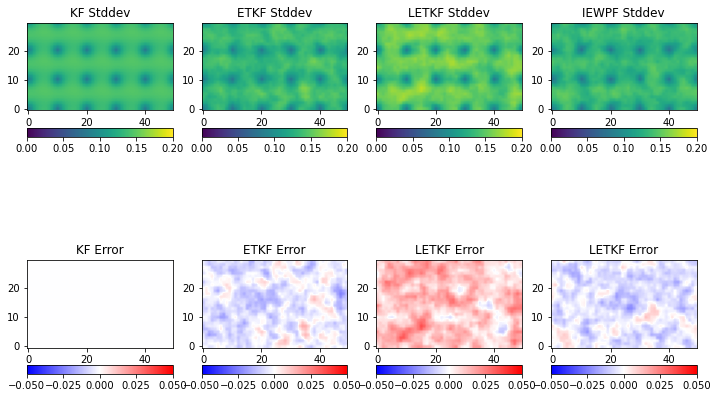

In [37]:
comparer.stddev_plots()

In [38]:
stddev_rmse_kf, stddev_rmse_etkf, stddev_rmse_letkf, stddev_rmse_iewpf = comparer.stddev_rmse()

print("RMSE of KF = ", stddev_rmse_kf)
print("RMSE of ETKF = ", stddev_rmse_etkf)
print("RMSE of LETKF = ", stddev_rmse_letkf)
print("RMSE of IEWPF = ", stddev_rmse_iewpf)

RMSE of KF =  0.0
RMSE of ETKF =  0.2858537406174246
RMSE of LETKF =  0.5250601616034751
RMSE of IEWPF =  0.2909451853330927


In [39]:
reload(Comparer)
comparer = Comparer.Comparer(statistics_kf, statistics_etkf, statistics_letkf, statistics_iewpf)

In [40]:
comparer.set_poi([0,0])
comparer.set_poi([25,15])
comparer.set_poi([1,0])

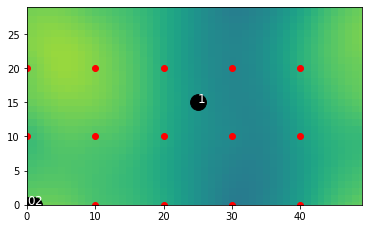

In [41]:
comparer.poi_plot(observation)

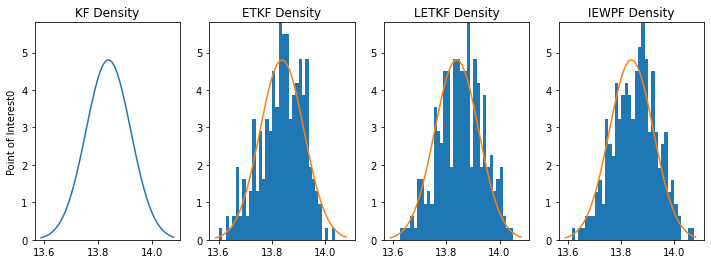

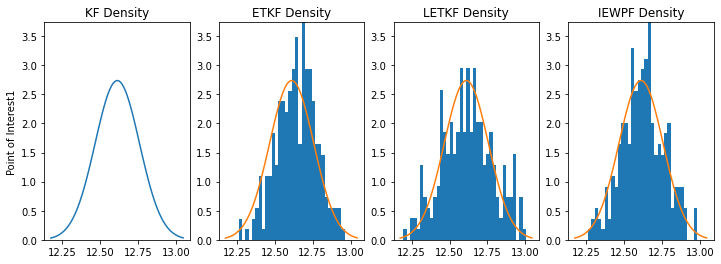

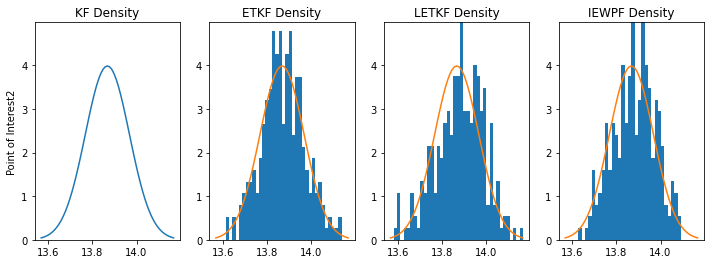

In [42]:
comparer.poi_hist(0)
comparer.poi_hist(1)
comparer.poi_hist(2)

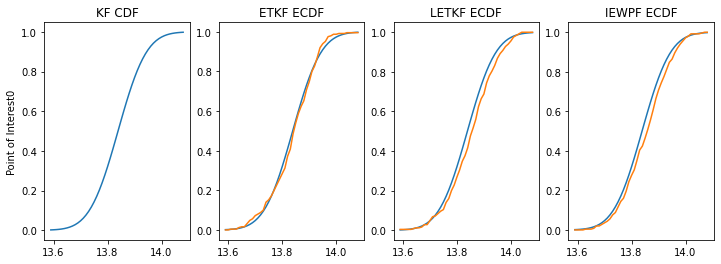

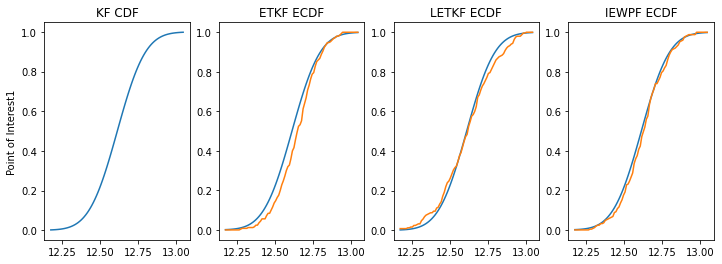

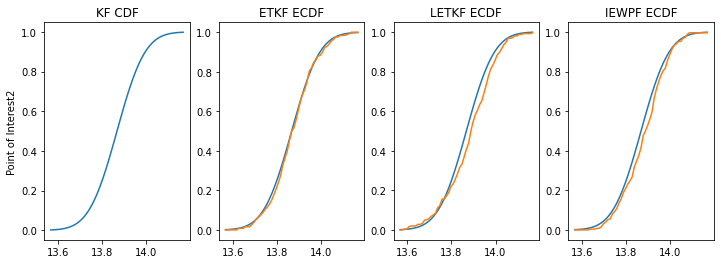

In [43]:
cdf0, ecdf_etkf0, ecdf_letkf0, ecdf_iewpf0 = comparer.poi_ecdf_plots(0)
cdf1, ecdf_etkf1, ecdf_letkf1, ecdf_iewpf1 = comparer.poi_ecdf_plots(1)
cdf2, ecdf_etkf2, ecdf_letkf2, ecdf_iewpf2 = comparer.poi_ecdf_plots(2)

In [44]:
save_cdf = False

In [45]:
if save_cdf: 
    import numpy as np
    import datetime 
    
    if result_timestamp is None:
        result_timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    filepath = "experiment_files/experiment_" + timestamp + "/"
    cdf_file = filepath + "cdf_" + result_timestamp
    
    x = np.arange(10,15,0.01)
    cdf_table = np.column_stack((x,cdf0(x),cdf1(x),cdf2(x)))
    np.savetxt(cdf_file, cdf_table)

    ecdf_file = filepath + "ecdf_" + result_timestamp

    y_ecdf = np.arange(0,1,1/N_e)+1/N_e
    ecdf_table = np.column_stack( (y_ecdf, ecdf_etkf0, ecdf_letkf0, ecdf_iewpf0) ) 
    ecdf_table = np.column_stack( (ecdf_table, ecdf_etkf1, ecdf_letkf1, ecdf_iewpf1))
    ecdf_table = np.column_stack( (ecdf_table, ecdf_etkf2, ecdf_letkf2, ecdf_iewpf2))
    ecdf_table = np.row_stack( (np.repeat(0,10), ecdf_table, np.hstack((np.array([1]),np.repeat(15,9)))) ) 
    np.savetxt(ecdf_file, ecdf_table)

In [46]:
ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(0)

print("Difference at pos0 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos0 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos0 (IEWPF) = ",ecdf_err_iewpf)

ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(1)

print("Difference at pos1 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos1 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos1 (IEWPF) = ",ecdf_err_iewpf)

ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(2)

print("Difference at pos2 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos2 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos2 (IEWPF) = ",ecdf_err_iewpf)

/home/florianb/advectionDiffusion/Comparer.py:406: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ecdf_err_etkf = scipy.integrate.quad(diff_etkf, xmin, xmax, limit=100)[0]
/home/florianb/advectionDiffusion/Comparer.py:407: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and call

Difference at pos0 (ETKF) =  0.007846665365336198
Difference at pos0 (LETKF) =  0.015083093852642785
Difference at pos0 (IEWPF) =  0.014707424917732356
Difference at pos1 (ETKF) =  0.03376167537890202
Difference at pos1 (LETKF) =  0.022662405278369192
Difference at pos1 (IEWPF) =  0.01554933808424269
Difference at pos2 (ETKF) =  0.006099264328940286
Difference at pos2 (LETKF) =  0.019565838625936756
Difference at pos2 (IEWPF) =  0.016292326285618913


## Correlation Study

Analytic correlation of two points $s_0$ at time $t_0$ and $s_1$ at time $t_1 = t_0 + \Delta t$ where sites are chosen in advection direction

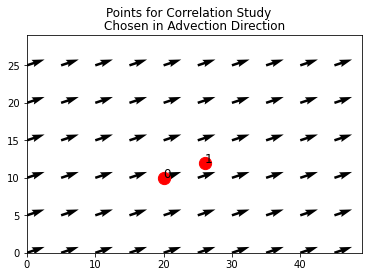

In [47]:
points = [[20,10],[26,12]]

simulator.plot_correlation_points(points)


Analytical calculations as suggested by Jo

In [48]:
statistics_kf.evaluate_correlation(points)

0.24827995811963646

Empirical estimations

$Corr = \frac{1}{N_e-1} \frac{1}{\sigma_{t=9}(x_0)\sigma_{t=10}(x_2)} \sum (c^e_{t=9}(x_0) - \overline{c_{t=9}(x_0)})(c^e_{t=10}(x_1) - \overline{c_{t=10}(x_1)}) $

In [49]:
statistics_etkf.evaluate_correlation(points)

0.23690310550059543

In [50]:
statistics_letkf.evaluate_correlation(points)

0.3585237131107141

In [51]:
statistics_iewpf.evaluate_correlation(points)

0.22680323958496523

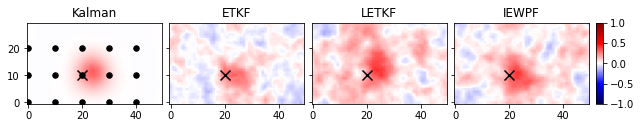

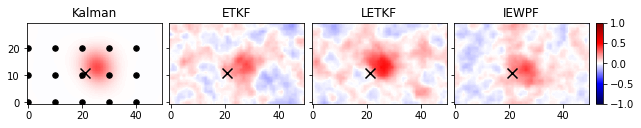

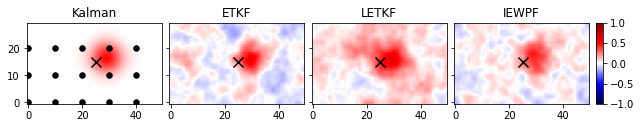

In [52]:
corr_ref_pois = [[20,10],[21,11],[25,15]]
comparer.set_corr_ref_pois(corr_ref_pois)

for p in range(len(corr_ref_pois)):
    corr_grid_kf, corr_grid_etkf, corr_grid_letkf, corr_grid_iewpf = comparer.corr_p2p_plot(p, observation)

In [53]:
save_corr_p2p = False

In [54]:
if save_corr_p2p: 
    import numpy as np
    import datetime 
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    if result_timestamp is None:
        result_timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
    filepath = "experiment_files/experiment_" + timestamp + "/"

    xgrid = np.arange(grid.nx)*grid.dx
    ygrid = np.arange(grid.ny)*grid.dy
    xgrids, ygrids = np.meshgrid(xgrid,ygrid)

    for i in [0,2]:
        corr_grid_kf, corr_grid_etkf, corr_grid_letkf, corr_grid_iewpf = comparer.corr_p2p_plot(i, observation)
    
        fig0, ax0 = plt.subplots(figsize=(6,4))
        im0 = ax0.imshow(corr_grid_kf.T, vmin=-1, vmax=1, cmap="seismic", origin="lower")
        ax0.scatter(corr_ref_pois[i][0], corr_ref_pois[i][1], s=150, c="black", marker="x")
        if i == 0:
            ax0.annotate(r"$s_3$",(21,7), fontsize=20)
        elif i == 2:
            ax0.annotate(r"$s_2$",(26,12), fontsize=20)
        ax0.scatter(np.array(observation.positions)[:,0],np.array(observation.positions)[:,1], c="black", s=30)
        plt.savefig(filepath + "corr_p2p_kf_" + str(i) + "_" + result_timestamp + ".png")
        plt.show()

        table_corr_kf = np.column_stack((xgrids.flatten(), ygrids.flatten(), corr_grid_kf.T.flatten()))
        np.savetxt(filepath + "corr_p2p_kf"+str(i)+".csv", table_corr_kf, header='x, y, corr', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')

        
        fig1, ax1 = plt.subplots(figsize=(6,4))
        im1 = ax1.imshow(corr_grid_etkf.T, vmin=-1, vmax=1, cmap="seismic", origin="lower")
        ax1.scatter(corr_ref_pois[i][0], corr_ref_pois[i][1], s=150, c="black", marker="x")
        plt.savefig(filepath + "corr_p2p_etkf_" + str(i) + "_" + result_timestamp + ".png")
        plt.show()

        table_corr_etkf = np.column_stack((xgrids.flatten(), ygrids.flatten(), corr_grid_etkf.T.flatten()))
        np.savetxt(filepath + "corr_p2p_etkf"+str(i)+".csv", table_corr_etkf, header='x, y, corr', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')


        fig2, ax2 = plt.subplots(figsize=(6,4))
        im2 = ax2.imshow(corr_grid_letkf.T, vmin=-1, vmax=1, cmap="seismic", origin="lower")
        ax2.scatter(corr_ref_pois[i][0], corr_ref_pois[i][1], s=150, c="black", marker="x")
        ax_divider = make_axes_locatable(ax2)
        ax_cb = ax_divider.append_axes("right", size="3%", pad="5%")
        cbar = plt.colorbar(im2, cax=ax_cb)
        cbar.ax.tick_params(labelsize=14) 
        plt.savefig(filepath + "corr_p2p_letkf_" + str(i) + "_" + result_timestamp + ".png")
        plt.show()

        table_corr_letkf = np.column_stack((xgrids.flatten(), ygrids.flatten(), corr_grid_letkf.T.flatten()))
        np.savetxt(filepath + "corr_p2p_letkf"+str(i)+".csv", table_corr_letkf, header='x, y, corr', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')


        fig3, ax3 = plt.subplots(figsize=(6,4))
        im3 = ax3.imshow(corr_grid_iewpf.T, vmin=-1, vmax=1, cmap="seismic", origin="lower")
        ax3.scatter(corr_ref_pois[i][0], corr_ref_pois[i][1], s=150, c="black", marker="x")
        plt.savefig(filepath + "corr_p2p_iewpf_" + str(i) + "_" + result_timestamp + ".png")
        plt.show()

        table_corr_iewpf = np.column_stack((xgrids.flatten(), ygrids.flatten(), corr_grid_iewpf.T.flatten()))
        np.savetxt(filepath + "corr_p2p_iewpf"+str(i)+".csv", table_corr_iewpf, header='x, y, corr', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')

        print("Total error ETKF ", np.linalg.norm(corr_grid_kf - corr_grid_etkf))
        print("Total error LETKF ", np.linalg.norm(corr_grid_kf - corr_grid_letkf))
        print("Total error IEWPF ", np.linalg.norm(corr_grid_kf - corr_grid_iewpf))

        X, Y = np.meshgrid( np.arange(5,grid.nx,10), np.arange(5,grid.ny,10) )
        advection_table = np.column_stack((X.flatten(), Y.flatten(), np.repeat(simulator.v[0],len(X.flatten())), np.repeat(simulator.v[1],len(Y.flatten()))))
        np.savetxt(filepath + "advection.csv", advection_table, header='x y u v', comments='# ',delimiter=' ', newline='\n',  fmt='%1.4f')


In [55]:
print("Maximal correlation KF", np.max(corr_grid_kf))
print("Maximal correlation ETKF", np.max(corr_grid_etkf))
print("Maximal correlation LETKF", np.max(corr_grid_letkf))
print("Maximal correlation IEWPF", np.max(corr_grid_iewpf))

Maximal correlation KF 0.485175534995277
Maximal correlation ETKF 0.557270006310062
Maximal correlation LETKF 0.5915268139663548
Maximal correlation IEWPF 0.47276894619388676


In [56]:
import numpy as np
print("ETKF difference ",  np.linalg.norm(corr_grid_kf - corr_grid_etkf))
print("LETKF difference ", np.linalg.norm(corr_grid_kf - corr_grid_letkf))
print("IEWPF difference ", np.linalg.norm(corr_grid_kf - corr_grid_iewpf))

ETKF difference  2.6087669898679433
LETKF difference  3.6235380442606036
IEWPF difference  2.1010181306665263


In [57]:
print("ETKF difference close to max ",  np.linalg.norm((corr_grid_kf - corr_grid_etkf)*(corr_grid_kf>0.1)))
print("LETKF difference close to max ", np.linalg.norm((corr_grid_kf - corr_grid_letkf)*(corr_grid_kf>0.1)))
print("IEWPF difference close to max ", np.linalg.norm((corr_grid_kf - corr_grid_iewpf)*(corr_grid_kf>0.1)))

ETKF difference close to max  0.8169446956453126
LETKF difference close to max  1.4512545427761807
IEWPF difference close to max  0.6507045068279205


In [58]:
print("ETKF difference far away max ",  np.linalg.norm((corr_grid_kf - corr_grid_etkf)*(corr_grid_kf<0.1)))
print("LETKF difference far away max ", np.linalg.norm((corr_grid_kf - corr_grid_letkf)*(corr_grid_kf<0.1)))
print("IEWPF difference far away max ", np.linalg.norm((corr_grid_kf - corr_grid_iewpf)*(corr_grid_kf<0.1)))

ETKF difference far away max  2.4775525366138327
LETKF difference far away max  3.320224120488775
IEWPF difference far away max  1.9977139009836458


#### Just some comparison of model error and ensemble covariance

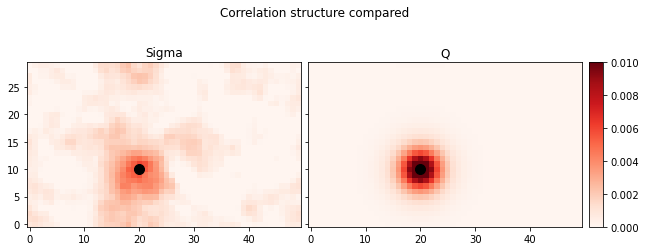

In [59]:
indicator_field = np.zeros((grid.ny,grid.nx))
indicator_field[points[0][1],points[0][0]] = 1.0
idx = np.where(indicator_field.flatten() != 0)

fig = plt.figure(figsize=(8,4))
fig.suptitle("Correlation structure compared")

from mpl_toolkits.axes_grid1 import AxesGrid

axs = AxesGrid(fig, (0.0,0.0,1.0,1.0), nrows_ncols=(1,2), axes_pad=0.1,
    cbar_mode="single", cbar_location="right", cbar_pad=0.1)

fig0 = axs[0].imshow(np.reshape(statistics_iewpf.cov[idx,:],(grid.ny,grid.nx)), origin="lower", vmin=0.0, vmax=0.01,cmap="Reds")
axs[0].set_title("Sigma")
axs[0].scatter(20, 10, s=100, c="black")

fig1 = axs[1].imshow(np.reshape(statistics_iewpf.simulator.Q[idx,:],(grid.ny,grid.nx)), origin="lower", vmin=0.0, vmax=0.01,cmap="Reds")
axs[1].set_title("Q")
axs[1].scatter(20, 10, s=100, c="black")

cbar = axs[0].cax.colorbar(fig0)